In [160]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy import optimize  # for Box-Cox calculations
from scipy.stats import norm
from matplotlib import rcParams # for ease of resizing plots
# Numpy version matters for scipy

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from fitter import Fitter # might require install, numpy version matters
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics

In [162]:
pip install xlrd==2.0.1

Note: you may need to restart the kernel to use updated packages.


## Importing Datasets

In [164]:
Core_PCE = pd.read_csv("C:/Users/naksh/OneDrive/Documents/Quarterly Core PCE Data.csv", parse_dates = True, index_col = 0)

In [165]:
Core_PCE.head()

,Core PCE
DATE,
1959-04-01,2.2
1959-07-01,2.7
1959-10-01,2.3
1960-01-01,1.2
1960-04-01,1.5


In [166]:
Core_PCE.rename(columns={'Core PCE': 'Core_PCE'}, inplace=True)
Core_PCE.head()

,Core_PCE
DATE,
1959-04-01,2.2
1959-07-01,2.7
1959-10-01,2.3
1960-01-01,1.2
1960-04-01,1.5


In [167]:
Actual_GDP = pd.read_csv("C:/Users/naksh/Downloads/GDPC1 (1).csv", parse_dates = True, index_col = 0)

In [168]:
Actual_GDP.rename(columns={'GDPC1': 'Actual_Real_GDP'}, inplace=True)
Actual_GDP.head()

,Actual_Real_GDP
DATE,
1947-01-01,2182.681
1947-04-01,2176.892
1947-07-01,2172.432
1947-10-01,2206.452
1948-01-01,2239.682


In [169]:
Potential_GDP = pd.read_excel("C:/Users/naksh/Downloads/GDPPOT.xls", engine = 'xlrd',parse_dates = True, index_col = 0)
Potential_GDP

,GDPPOT
observation_date,
1949-01-01,2256.084579
1949-04-01,2288.079745
1949-07-01,2321.232738
1949-10-01,2352.503145
1950-01-01,2384.662436
...,...
2033-10-01,27326.180000
2034-01-01,27445.780000
2034-04-01,27565.360000


In [170]:
Potential_GDP.rename(columns={'GDPPOT': 'Potential_Real_GDP'}, inplace=True)
Potential_GDP.head()

,Potential_Real_GDP
observation_date,
1949-01-01,2256.084579
1949-04-01,2288.079745
1949-07-01,2321.232738
1949-10-01,2352.503145
1950-01-01,2384.662436


In [171]:
Fed_Funds = pd.read_csv("C:/Users/naksh/OneDrive/Documents/Quarterly.csv", parse_dates = True, index_col = 0)
Fed_Funds.head()

,EFFR
DATE,
2000-07-01,6.5114285714285714
2000-10-01,6.4996774193548387
2001-01-01,5.6211475409836066
2001-04-01,4.3307812500000000
2001-07-01,3.4879365079365079


In [172]:
## Joining all the importing datasets into a single dataframe
Taylor_Rule = pd.concat([Core_PCE, Actual_GDP, Potential_GDP, Fed_Funds], axis=1)
Taylor_Rule.head()

,Core_PCE,Actual_Real_GDP,Potential_Real_GDP,EFFR
1947-01-01,NaN,2182.681,NaN,NaN
1947-04-01,NaN,2176.892,NaN,NaN
1947-07-01,NaN,2172.432,NaN,NaN
1947-10-01,NaN,2206.452,NaN,NaN
1948-01-01,NaN,2239.682,NaN,NaN


In [178]:
Taylor_Rule.dropna(inplace = True)
Taylor_Rule.head()

,Core_PCE,Actual_Real_GDP,Potential_Real_GDP,EFFR
2000-07-01,1.9,14145.312,13940.660485,6.5114285714285714
2000-10-01,2.0,14229.765,14071.401933,6.4996774193548387
2001-01-01,2.6,14183.120,14194.982061,5.6211475409836066
2001-04-01,1.5,14271.694,14311.539723,4.3307812500000000
2001-07-01,1.0,14214.516,14421.269311,3.4879365079365079


In [185]:
Taylor_Rule[['Actual_Real_GDP', 'Potential_Real_GDP']] = Taylor_Rule[['Actual_Real_GDP', 'Potential_Real_GDP']].round(2)
Taylor_Rule.head()

,Core_PCE,Actual_Real_GDP,Potential_Real_GDP,EFFR
2000-07-01,1.9,14145.31,13940.66,6.5114285714285714
2000-10-01,2.0,14229.76,14071.40,6.4996774193548387
2001-01-01,2.6,14183.12,14194.98,5.6211475409836066
2001-04-01,1.5,14271.69,14311.54,4.3307812500000000
2001-07-01,1.0,14214.52,14421.27,3.4879365079365079


In [187]:
## Adding a new variable called Output Gap:
Taylor_Rule['Output_Gap'] = ((Taylor_Rule['Actual_Real_GDP'] - Taylor_Rule['Potential_Real_GDP']) / Taylor_Rule['Potential_Real_GDP']) * 100
Taylor_Rule.head()

,Core_PCE,Actual_Real_GDP,Potential_Real_GDP,EFFR,Output_Gap
2000-07-01,1.9,14145.31,13940.66,6.5114285714285714,1.468008
2000-10-01,2.0,14229.76,14071.40,6.4996774193548387,1.125403
2001-01-01,2.6,14183.12,14194.98,5.6211475409836066,-0.083551
2001-04-01,1.5,14271.69,14311.54,4.3307812500000000,-0.278447
2001-07-01,1.0,14214.52,14421.27,3.4879365079365079,-1.433646


In [189]:
# Make a backup of the Core PCE series
original_core_pce = Taylor_Rule['Core_PCE'].copy()

# Run your structural break tests here (ruptures, Zivot-Andrews, etc.)

# If needed, restore the original Core PCE values after the tests
Taylor_Rule['Original_Core_PCE'] = original_core_pce

In [191]:
Taylor_Rule.head()

,Core_PCE,Actual_Real_GDP,Potential_Real_GDP,EFFR,Output_Gap,Original_Core_PCE
2000-07-01,1.9,14145.31,13940.66,6.5114285714285714,1.468008,1.9
2000-10-01,2.0,14229.76,14071.40,6.4996774193548387,1.125403,2.0
2001-01-01,2.6,14183.12,14194.98,5.6211475409836066,-0.083551,2.6
2001-04-01,1.5,14271.69,14311.54,4.3307812500000000,-0.278447,1.5
2001-07-01,1.0,14214.52,14421.27,3.4879365079365079,-1.433646,1.0


## Stationarity and Structural Breaks Tests:

In [194]:
## ADF test for Stationarity:
from statsmodels.tsa.stattools import adfuller, kpss

In [196]:
result_1 = adfuller(Taylor_Rule['Core_PCE'])

# Extract and display the results
print('ADF Statistic:', result_1[0])
print('p-value:', result_1[1])
print('Critical Values:', result_1[4])

# Interpret the result
if result_1[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary")

## Null hypothesis here is that the series is stationary

ADF Statistic: -2.636433953857777
p-value: 0.08569844982784419
Critical Values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}
Fail to reject the null hypothesis - The series is non-stationary


## Bai Perron Test
Financial time series generally tend to have structural breaks in whose presence ADF fails. Hence first we run a Bai-Perron test to check presence of multiple structural breaks

Detected breakpoints: [80, 85, 90, 96]


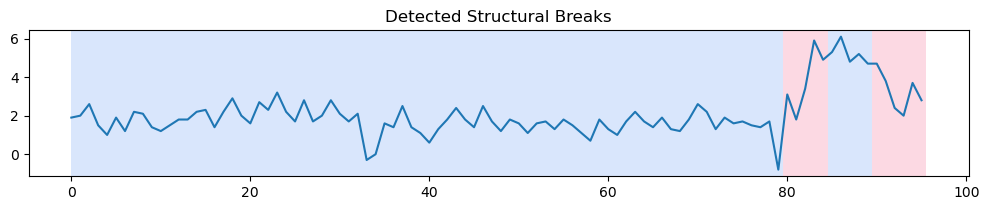

In [199]:
import ruptures as rpt
model = "l2"
y = Taylor_Rule['Core_PCE'].values
algo = rpt.Binseg(model=model).fit(y)

# Testing for Structural Breaks
result = algo.predict(n_bkps=3)  # n_bkps represents the number of breakpoints to detect

# Displaying the breaks
print(f'Detected breakpoints: {result}')

# Visualizing the breaks
rpt.display(y, result)
plt.title('Detected Structural Breaks')
plt.show()

In [201]:
from statsmodels.tsa.stattools import zivot_andrews

y = Taylor_Rule['Core_PCE']


result = zivot_andrews(y, maxlag=12, regression='c')

# Display the results
print(f'Zivot-Andrews test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[2]}')
print(f'Break location (index): {result[3]}')


if result[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary with a structural break")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary even with a structural break")

Zivot-Andrews test statistic: -6.319340136949154
p-value: 0.0004933900938796198
Critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Break location (index): 3
Reject the null hypothesis - The series is stationary with a structural break


In [203]:
result_2 = adfuller(Taylor_Rule['Actual_Real_GDP'])

#displaying the results
print('ADF Statistic:', result_2[0])
print('p-value:', result_2[1])
print('Critical Values:', result_1[4])


if result_2[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary")


ADF Statistic: 0.8096298847765383
p-value: 0.9917900328714232
Critical Values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}
Fail to reject the null hypothesis - The series is non-stationary


Detected breakpoints: [20, 55, 80, 96]


Text(0.5, 1.0, 'Detected Structural Breaks')

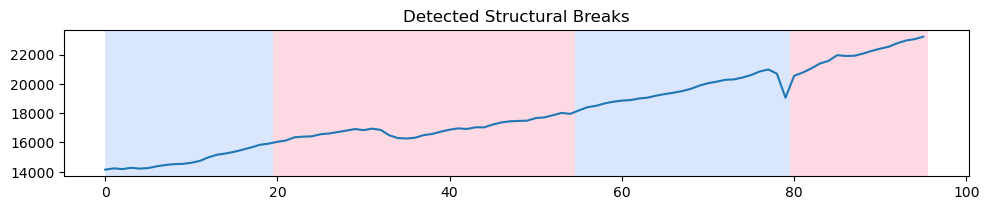

In [205]:
model = "l2"
y_1 = Taylor_Rule['Actual_Real_GDP'].values
algo = rpt.Binseg(model=model).fit(y_1)

# Testing for Structural Breaks
result = algo.predict(n_bkps=3)  # 'n_bkps' is the number of breakpoints to detect

# Displaying the breaks
print(f'Detected breakpoints: {result}')

# Visualizing the breakpoints
rpt.display(y_1, result)
plt.title('Detected Structural Breaks')

In [207]:
y_1 = Taylor_Rule['Actual_Real_GDP']

result = zivot_andrews(y, maxlag=12, regression='c')


print(f'Zivot-Andrews test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[2]}')
print(f'Break location (index): {result[3]}')


if result[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary with a structural break")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary even with a structural break")

Zivot-Andrews test statistic: -6.319340136949151
p-value: 0.0004933900938796225
Critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Break location (index): 3
Reject the null hypothesis - The series is stationary with a structural break


In [209]:
result_3 = adfuller(Taylor_Rule['Potential_Real_GDP'])


print('ADF Statistic:', result_3[0])
print('p-value:', result_3[1])
print('Critical Values:', result_3[4])


if result_3[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary")


ADF Statistic: 2.0166275842154797
p-value: 0.9986941712476181
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}
Fail to reject the null hypothesis - The series is non-stationary


Detected breakpoints: [20, 50, 75, 96]


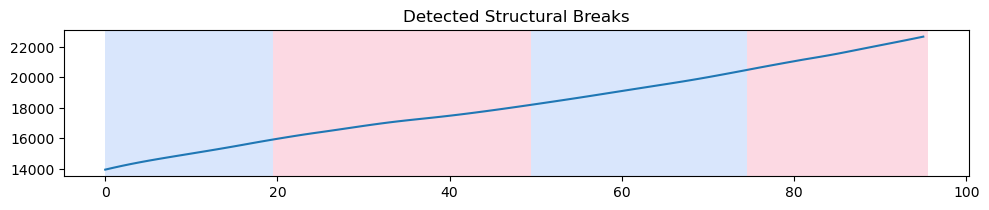

In [211]:
model = "l2"
y_2 = Taylor_Rule['Potential_Real_GDP'].values
algo = rpt.Binseg(model=model).fit(y_2)

# Testing for Structural Breaks
result = algo.predict(n_bkps=3)  # 'n_bkps' is the number of breakpoints to detect

# Displaying the Structural Breaks
print(f'Detected breakpoints: {result}')

# Visualizing the Structural Breaks
rpt.display(y_2, result)
plt.title('Detected Structural Breaks')
plt.show()

In [213]:
y_2 = Taylor_Rule['Potential_Real_GDP']

result = zivot_andrews(y, maxlag=12, regression='c')

print(f'Zivot-Andrews test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[2]}')
print(f'Break location (index): {result[3]}')


if result[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary with a structural break")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary even with a structural break")

Zivot-Andrews test statistic: -6.319340136949151
p-value: 0.0004933900938796225
Critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Break location (index): 3
Reject the null hypothesis - The series is stationary with a structural break


In [215]:
result_4 = adfuller(Taylor_Rule['EFFR'])

print('ADF Statistic:', result_4[0])
print('p-value:', result_4[1])
print('Critical Values:', result_4[4])

if result_4[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary")


ADF Statistic: -3.1959982439835546
p-value: 0.020217488239935185
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}
Reject the null hypothesis - The series is stationary


Detected breakpoints: [20, 30, 90, 96]


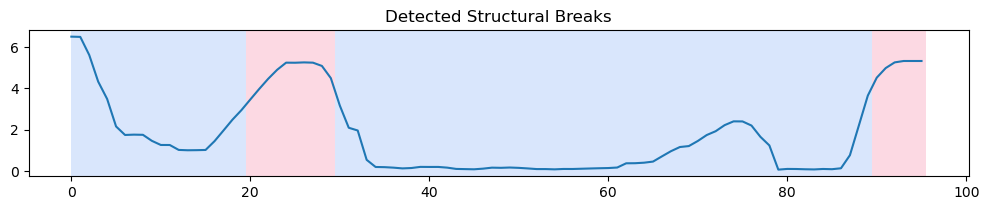

In [217]:
model = "l2"
Taylor_Rule['EFFR'] = pd.to_numeric(Taylor_Rule['EFFR'], errors='coerce')
y_3 = Taylor_Rule['EFFR'].values
algo = rpt.Binseg(model=model).fit(y_3)

# Testing for Structural Breaks
result = algo.predict(n_bkps=3)  # 'n_bkps' is the number of breakpoints to detect

# Displaying the Structural Breaks
print(f'Detected breakpoints: {result}')

# Visualizing the Structural Breaks
rpt.display(y_3, result)
plt.title('Detected Structural Breaks')
plt.show()

In [219]:
y_3 = Taylor_Rule['EFFR']

result = zivot_andrews(y, maxlag=12, regression='c')

print(f'Zivot-Andrews test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[2]}')
print(f'Break location (index): {result[3]}')

if result[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary with a structural break")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary even with a structural break")

Zivot-Andrews test statistic: -6.319340136949151
p-value: 0.0004933900938796225
Critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Break location (index): 3
Reject the null hypothesis - The series is stationary with a structural break


In [221]:
result_5 = adfuller(Taylor_Rule['Output_Gap'])

print('ADF Statistic:', result_5[0])
print('p-value:', result_5[1])
print('Critical Values:', result_5[4])

if result_5[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary")


ADF Statistic: -2.937865583585376
p-value: 0.04111861805488217
Critical Values: {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
Reject the null hypothesis - The series is stationary


Detected breakpoints: [30, 55, 85, 96]


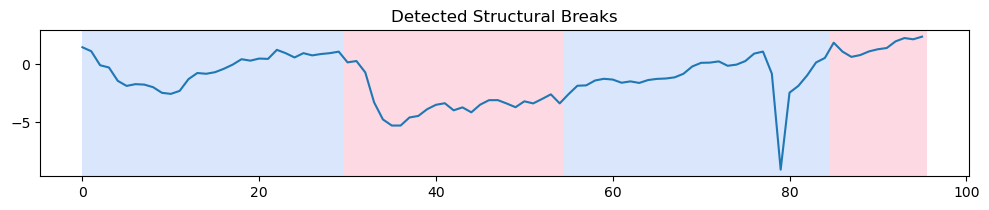

In [223]:
model = "l2"
y_4 = Taylor_Rule['Output_Gap'].values
algo = rpt.Binseg(model=model).fit(y_4)

## Testing for Structural Breaks
result = algo.predict(n_bkps=3)  # 'n_bkps' is the number of breakpoints to detect

## Displaying the Structural breaks
print(f'Detected breakpoints: {result}')

## Visualizing the results
rpt.display(y_4, result)
plt.title('Detected Structural Breaks')
plt.show()

In [225]:
y_4 = Taylor_Rule['Output_Gap'].dropna()  # Ensure there are no missing values

result = zivot_andrews(y, maxlag=12, regression='c')

print(f'Zivot-Andrews test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[2]}')
print(f'Break location (index): {result[3]}')

if result[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary with a structural break")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary even with a structural break")

Zivot-Andrews test statistic: -6.319340136949151
p-value: 0.0004933900938796225
Critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Break location (index): 3
Reject the null hypothesis - The series is stationary with a structural break


## AR, MA and ARMA process checks

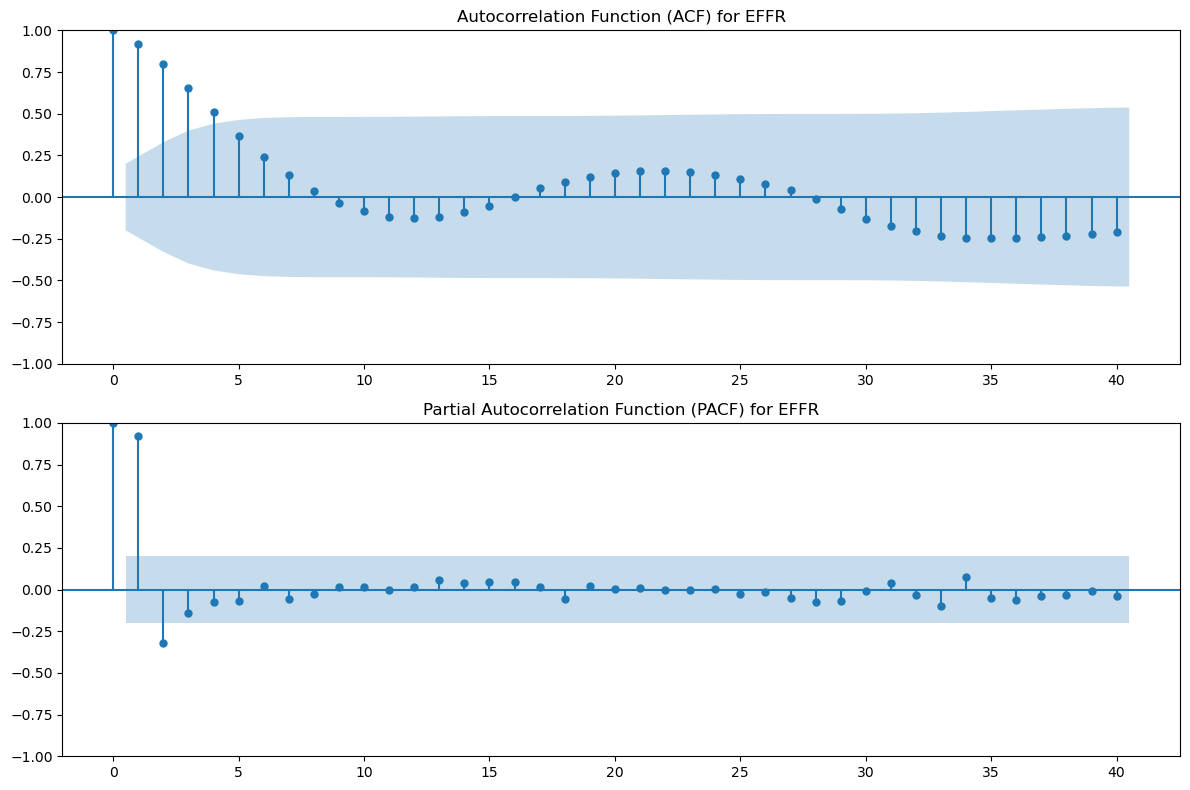

In [233]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## ACF and PACF for sour Effective Federal Funds rate variables
series = Taylor_Rule['EFFR']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, lags=40, ax=ax[0])
plot_pacf(series, lags=40, ax=ax[1])

ax[0].set_title('Autocorrelation Function (ACF) for EFFR')
ax[1].set_title('Partial Autocorrelation Function (PACF) for EFFR')

plt.tight_layout()
plt.show()

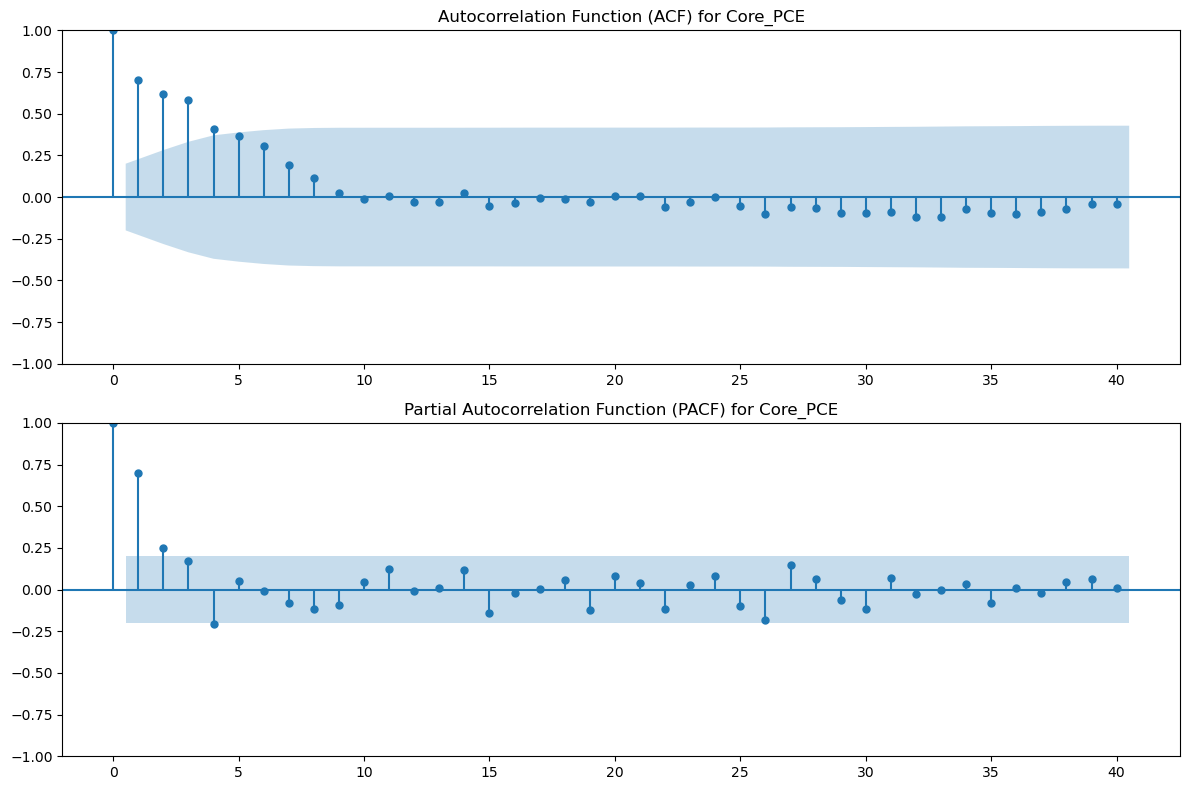

In [235]:
# ACF and PACF for Core_PCE
series = Taylor_Rule['Original_Core_PCE']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, lags=40, ax=ax[0])
plot_pacf(series, lags=40, ax=ax[1])

ax[0].set_title('Autocorrelation Function (ACF) for Core_PCE')
ax[1].set_title('Partial Autocorrelation Function (PACF) for Core_PCE')

plt.tight_layout()
plt.show()

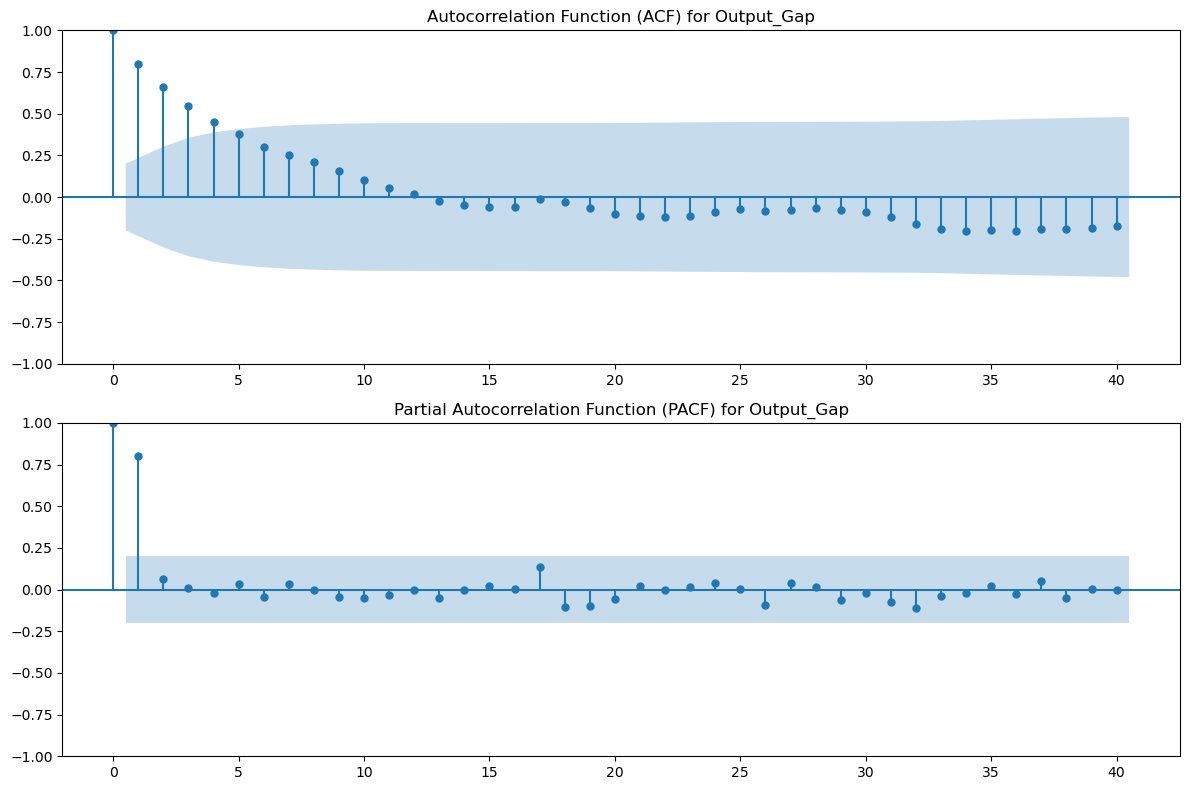

In [239]:
# ACF and PACF for Output Gap
series = Taylor_Rule['Output_Gap']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, lags=40, ax=ax[0])
plot_pacf(series, lags=40, ax=ax[1])

ax[0].set_title('Autocorrelation Function (ACF) for Output_Gap')
ax[1].set_title('Partial Autocorrelation Function (PACF) for Output_Gap')

# Display the plots
plt.tight_layout()
plt.show()

Visually we can see the presence of AR and MA characterstics. However to be statistically sure we will now run different model specifications and compare their AIC and BIC measures of good fit

## Regression Building:

We now code the Multiple Regression model, once without considering the AR, MA and ARMA processes and then aaccountign for these characterstics in our regression

In [262]:
df = Taylor_Rule[['EFFR', 'Original_Core_PCE', 'Output_Gap']]

# Calculating the Inflation Deviation (Core PCE - 2)
df['Inflation_Deviation'] = df['Original_Core_PCE'] - 2

# Defining predictors (X) and target (y) using the provided formula
X = df[['Inflation_Deviation', 'Output_Gap']]
y = df['EFFR']

# Splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Adding a constant to predictors for the intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fitting the MLR model using the adjusted formula
mlr_model_taylor = sm.OLS(y_train, X_train_const).fit()

# Printing the model summary
print(mlr_model_taylor.summary())

# Predict on the test set
y_pred_mlr_taylor = mlr_model_taylor.predict(X_test_const)

# Calculating RMSE for the adjusted MLR model
from sklearn.metrics import mean_squared_error
rmse_mlr_taylor = np.sqrt(mean_squared_error(y_test, y_pred_mlr_taylor))
print(f'RMSE for Taylor Rule-Based Multiple Linear Regression: {rmse_mlr_taylor}')

                            OLS Regression Results                            
Dep. Variable:                   EFFR   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     60.13
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           3.69e-16
Time:                        15:33:47   Log-Likelihood:                -116.92
No. Observations:                  76   AIC:                             239.8
Df Residuals:                      73   BIC:                             246.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8791    

C:\Users\krish\AppData\Local\Temp\ipykernel_49684\1710905048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inflation_Deviation'] = df['Original_Core_PCE'] - 2


In [266]:
# Original data
df = Taylor_Rule[['EFFR', 'Original_Core_PCE', 'Output_Gap']]

# Calculate the Inflation Deviation (Core_PCE - 2)
df['Inflation_Deviation'] = df['Original_Core_PCE'] - 2

# Ftting AR(1) model to Inflation Deviation to get residuals
# Use ARIMA with d=0 to represent ARMA(1,0)
arma_model = sm.tsa.ARIMA(df['Inflation_Deviation'], order=(1, 0, 0)).fit()

# Creating lagged residuals from the AR(1) model for the MA(1) part
df['Inflation_Deviation_residuals'] = arma_model.resid
df['Inflation_Deviation_residuals_lag1'] = df['Inflation_Deviation_residuals'].shift(1)

# Creatinf lagged terms for EFFR (AR(2))
df['EFFR_lag1'] = df['EFFR'].shift(1)
df['EFFR_lag2'] = df['EFFR'].shift(2)

# Creating lagged terms for Inflation Deviation (AR(1))
df['Inflation_Deviation_lag1'] = df['Inflation_Deviation'].shift(1)

# Creating lagged terms for Output Gap (AR(1))
df['Output_Gap_lag1'] = df['Output_Gap'].shift(1)

# Dropping rows with NaN values resulting from shifts
df = df.dropna()

# De0fining predictors (X) and target (y), including ARMA(1,1) terms for Inflation Deviation
X = df[['Inflation_Deviation', 'Inflation_Deviation_lag1', 'Inflation_Deviation_residuals_lag1', 
        'Output_Gap', 'Output_Gap_lag1', 'EFFR_lag1', 'EFFR_lag2']]
y = df['EFFR']

# Splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Adding a constant to predictors for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fitting the MLR model with ARMA(1,1) terms for Inflation Deviation
mlr_model_taylor_lagged_arma = sm.OLS(y_train, X_train_const).fit()

# Printing the model summary
print(mlr_model_taylor_lagged_arma.summary())

# Predicting on the test set
y_pred_mlr_taylor_lagged_arma = mlr_model_taylor_lagged_arma.predict(X_test_const)

# Calculating RMSE for the adjusted MLR model with ARMA(1,1) terms
rmse_mlr_taylor_lagged_arma = np.sqrt(mean_squared_error(y_test, y_pred_mlr_taylor_lagged_arma))
print(f'RMSE for Taylor Rule-Based Multiple Linear Regression (with ARMA(1,1) Inflation Deviation): {rmse_mlr_taylor_lagged_arma}')

                            OLS Regression Results                            
Dep. Variable:                   EFFR   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     437.0
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           2.59e-53
Time:                        15:34:36   Log-Likelihood:               -0.56176
No. Observations:                  75   AIC:                             17.12
Df Residuals:                      67   BIC:                             35.66
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

C:\Users\krish\AppData\Local\Temp\ipykernel_49684\1915041671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inflation_Deviation'] = df['Original_Core_PCE'] - 2
C:\Users\krish\AppData\Local\Temp\ipykernel_49684\1915041671.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inflation_Deviation_residuals'] = arma_model.resid


## Serial Correlation and Heteroskedasticity test for our MLR:

In [269]:
## Lagged MLS

from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

# Extract residuals from the model
residuals = mlr_model_taylor_lagged_arma.resid

# 1. Durbin-Watson Test for Serial Correlation
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# 3. Breusch-Pagan Test for Heteroskedasticity
bp_test = het_breuschpagan(residuals, mlr_model_taylor_lagged_arma.model.exog)
print(f'Breusch-Pagan test statistic: {bp_test[0]}, p-value: {bp_test[1]}')

## A value of Durbin_Watson test close to 2 tells us that there is no serial correlation 
## However, based on the low p value opf Breusch_Pagan test we reject the null of homoskedasticity

Durbin-Watson statistic: 2.047742332846562
Breusch-Pagan test statistic: 40.164240839855765, p-value: 1.1708785116429327e-06


In [271]:
## non Lagged MLR

# Extract residuals from the model
residuals_1 = mlr_model_taylor.resid

# 1. Durbin-Watson Test for Serial Correlation
dw_stat_1 = durbin_watson(residuals_1)
print(f'Durbin-Watson statistic: {dw_stat_1}')

# 3. Breusch-Pagan Test for Heteroskedasticity
bp_test_1 = het_breuschpagan(residuals_1, mlr_model_taylor.model.exog)
print(f'Breusch-Pagan test statistic: {bp_test_1[0]}, p-value: {bp_test_1[1]}')

## As expected the non lagged MLR has a serial correlation problem as we have not accounted for the lagged variables
## It also has heteroksedastic errors

Durbin-Watson statistic: 0.1717448064990808
Breusch-Pagan test statistic: 11.482632732913327, p-value: 0.003210539246269975


## Newey West Robust Error Models

In [286]:
# Original data
df = Taylor_Rule[['EFFR', 'Original_Core_PCE', 'Output_Gap']]

df['Inflation_Deviation'] = df['Original_Core_PCE'] - 2


arma_model = sm.tsa.ARIMA(df['Inflation_Deviation'], order=(1, 0, 0)).fit()

df['Inflation_Deviation_residuals'] = arma_model.resid
df['Inflation_Deviation_residuals_lag1'] = df['Inflation_Deviation_residuals'].shift(1)

df['EFFR_lag1'] = df['EFFR'].shift(1)
df['EFFR_lag2'] = df['EFFR'].shift(2)

df['Inflation_Deviation_lag1'] = df['Inflation_Deviation'].shift(1)

df['Output_Gap_lag1'] = df['Output_Gap'].shift(1)

df = df.dropna()

X = df[['Inflation_Deviation', 'Inflation_Deviation_lag1', 'Inflation_Deviation_residuals_lag1', 
        'Output_Gap', 'Output_Gap_lag1', 'EFFR_lag1', 'EFFR_lag2']]
y = df['EFFR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

mlr_model_taylor_lagged_arma = sm.OLS(y_train, X_train_const).fit()

# Apply Newey-West robust standard errors (HAC)
# 'maxlags' defines the number of lags to consider
nw_robust_model = mlr_model_taylor_lagged_arma.get_robustcov_results(cov_type='HAC', maxlags=4)

# Print the summary of the model with Newey-West standard errors
print(nw_robust_model.summary())

# Predict on the test set
y_pred_nw = nw_robust_model.predict(X_test_const)

# Calculate RMSE for the adjusted MLR model with Newey-West standard errors
from sklearn.metrics import mean_squared_error
rmse_nw = np.sqrt(mean_squared_error(y_test, y_pred_nw))
print(f'RMSE for MLR with Newey-West robust standard errors: {rmse_nw}')

                            OLS Regression Results                            
Dep. Variable:                   EFFR   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     447.0
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           1.24e-53
Time:                        15:36:18   Log-Likelihood:               -0.56176
No. Observations:                  75   AIC:                             17.12
Df Residuals:                      67   BIC:                             35.66
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

C:\Users\krish\AppData\Local\Temp\ipykernel_49684\2330848339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inflation_Deviation'] = df['Original_Core_PCE'] - 2
C:\Users\krish\AppData\Local\Temp\ipykernel_49684\2330848339.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inflation_Deviation_residuals'] = arma_model.resid


Creating a VAR model in python:

In [290]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Ensure only the necessary variables are used for VAR
df = df[['EFFR', 'Original_Core_PCE', 'Output_Gap']]

# Splitting the data into training (80%) and testing (20%) sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Standardizing the training data to avoid scaling issues
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

# Initialize the VAR model on the scaled training data
model = VAR(train_data_scaled)

# Set a very small number of lags (e.g., 1 or 2) to avoid instability
optimal_lags = 1  # Start with 1 lag

try:
    var_model_fit = model.fit(optimal_lags)
    # Print the summary of the fitted VAR model
    print(var_model_fit.summary())
except np.linalg.LinAlgError as e:
    print(f"Error during VAR model fitting: {e}")

# Forecasting for the same number of steps as the test set length
forecast_values = var_model_fit.forecast(y=train_data_scaled.values[-var_model_fit.k_ar:], steps=len(test_data_scaled))

# Inverse transform the forecasted values to the original scale
forecast_df_scaled = pd.DataFrame(forecast_values, index=test_data_scaled.index, 
                                  columns=['EFFR_forecast', 'Core_PCE_forecast', 'Output_Gap_forecast'])
forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df_scaled), index=forecast_df_scaled.index,
                           columns=forecast_df_scaled.columns)

# Combining forecasted and actual values for comparison
comparison_df = pd.concat([test_data, forecast_df], axis=1)
print("Forecasted vs Actual Values:")
print(comparison_df.head())

# Calculating the RMSE for each forecasted variable
rmse_effr = np.sqrt(mean_squared_error(test_data['EFFR'], forecast_df['EFFR_forecast']))
rmse_core_pce = np.sqrt(mean_squared_error(test_data['Original_Core_PCE'], forecast_df['Core_PCE_forecast']))
rmse_output_gap = np.sqrt(mean_squared_error(test_data['Output_Gap'], forecast_df['Output_Gap_forecast']))

print(f'RMSE for EFFR Forecast: {rmse_effr}')
print(f'RMSE for Core_PCE Forecast: {rmse_core_pce}')
print(f'RMSE for Output_Gap Forecast: {rmse_output_gap}')

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Oct, 2024
Time:                     15:37:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.39763
Nobs:                     74.0000    HQIC:                  -5.62222
Log likelihood:          -89.4677    FPE:                 0.00311681
AIC:                     -5.77126    Det(Omega_mle):      0.00266147
--------------------------------------------------------------------
Results for equation EFFR
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.026598         0.026362           -1.009           0.313
L1.EFFR                      0.826823         0.041947           19.711           0.000
L1.Original_Core_PCE         0.02

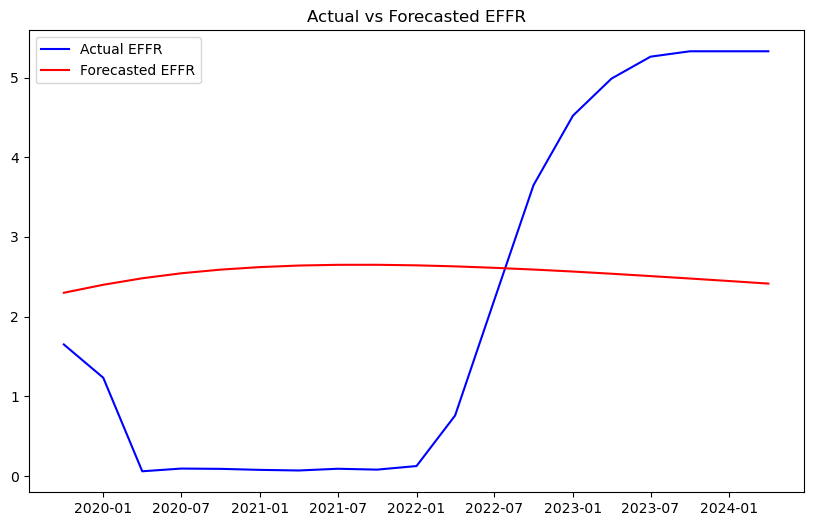

In [292]:
# Plot the actual vs. forecasted values for EFFR
plt.figure(figsize=(10, 6))
plt.plot(test_data['EFFR'], label='Actual EFFR', color='blue')
plt.plot(forecast_df['EFFR_forecast'], label='Forecasted EFFR', color='red')
plt.title('Actual vs Forecasted EFFR')
plt.legend()
plt.show()